# DSCI 100 - Proposal
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

Our project is centered around factors that influence a student’s decision to pursue higher education based on academic performance and additional factors. A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 
 
We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. The information collected includes student grades, social and study habits, and family background.  The data set tracks first and second period grades as well as final grades in Portugese
 
We will try to answer the following question in this report:
Can we predict whether a student  pursue higher education,  given sex, address, parent education, class failures, family educational support, and Portuguese grades?

## Preliminary exploratory data analysis

In [10]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [11]:
#Read data set from the web into R
student_port <- read_delim("data/student-por.csv",delim = ";")

# Clean and wrangle data into tidy format
student_select <- student_port %>%
                select("sex", "address", "Medu", "Fedu", "failures", "famsup", "higher", "G1", "G2", "G3") %>%
                mutate(higher = as_factor(higher))

# Obtain training set:
# We chose strata = 0.75 since the data set is large enough that we will still 
# have a reasonable amount of training and testing data with this split.
student_split <- initial_split(student_select, prop = 0.75, strata = higher) 

student_train <- training(student_split)
student_train

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



sex,address,Medu,Fedu,failures,famsup,higher,G1,G2,G3
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
F,U,4,4,0,no,yes,0,11,11
F,U,4,2,0,yes,yes,14,14,14
M,U,4,3,0,yes,yes,12,12,13
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
F,U,1,1,0,no,yes,11,12,9
M,U,3,1,0,no,yes,10,10,10
M,R,3,2,0,no,yes,10,11,11


In [12]:
# number of observations in higher(target variable)
counts <- student_train %>%
        group_by(higher) %>%
        summarize(n=n())   
counts

# average grade of term 1, term 2, and final Portuguese grade
ave_grade <- student_train %>%
            summarize(G1 = mean(G1), G2 = mean(G2), G3 = mean(G3))
ave_grade

`summarise()` ungrouping output (override with `.groups` argument)



higher,n
<fct>,<int>
yes,435
no,52


G1,G2,G3
<dbl>,<dbl>,<dbl>
11.44559,11.63244,11.9692


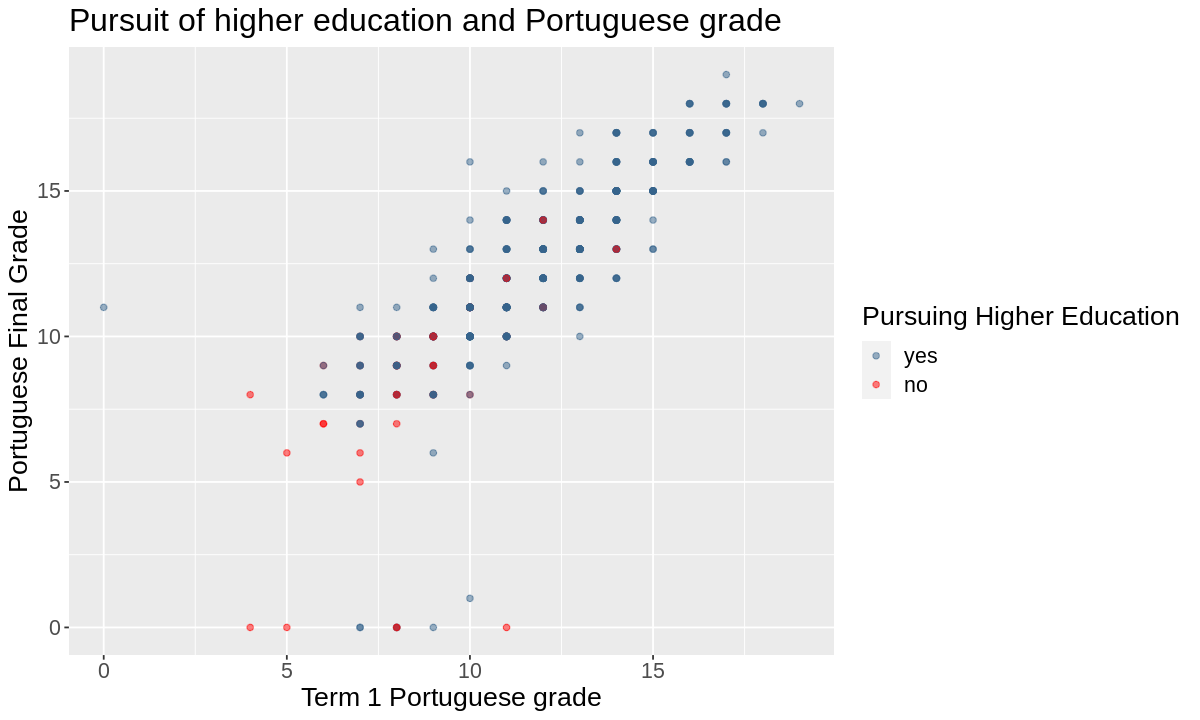

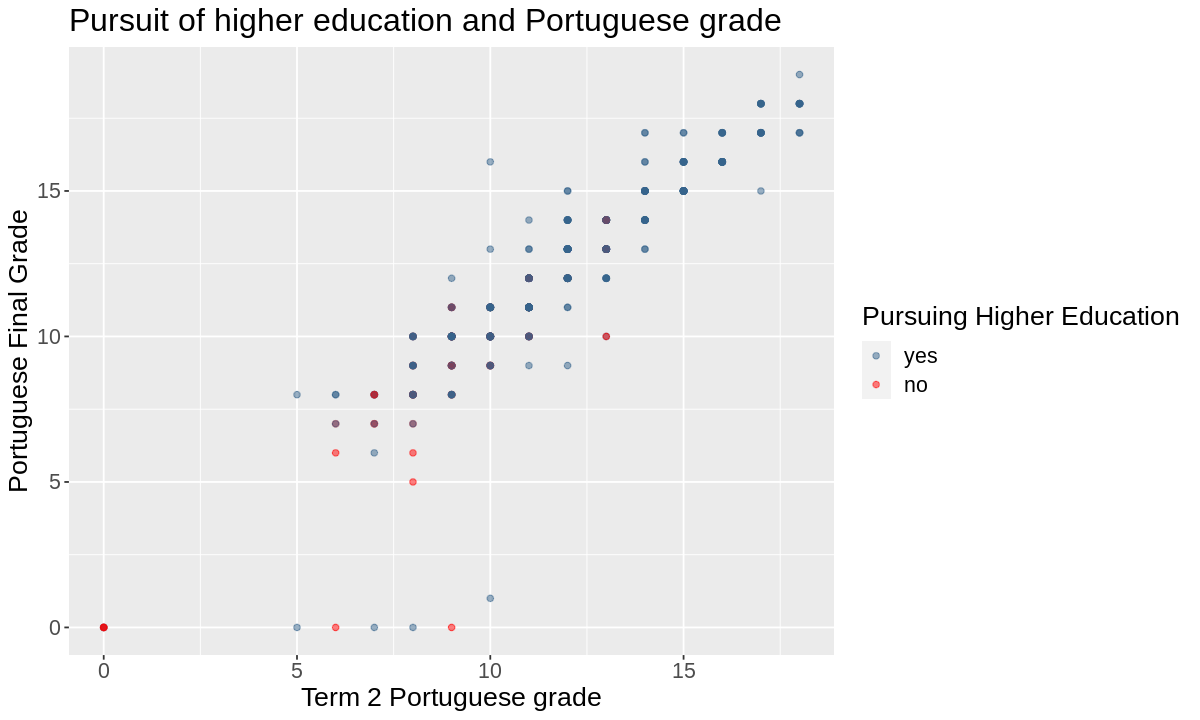

In [19]:
options(repr.plot.width=10, repr.plot.height=6)

# comparing the distribution of Portuguese grades and higher
# Term 1 vs Final Portuguese grades
student_por_plot1 <- student_train %>%
                select(G1, G3, higher) %>%
                ggplot(aes(x = G1, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 1 Portuguese grade", 
                     y = "Portuguese Final Grade", 
                     colour = "Pursuing Higher Education", 
                     title = "Pursuit of higher education and Portuguese grade")+
                scale_colour_manual(values = c("yes" = "steelblue4","no"="red")) +
                theme(text = element_text(size=16))        

# Term 2 vs Final Portuguese grades
student_por_plot2 <- student_train %>%
                select(G2, G3, higher) %>%
                ggplot(aes(x = G2, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 2 Portuguese grade", 
                     y = "Portuguese Final Grade", 
                     colour = "Pursuing Higher Education", 
                     title = "Pursuit of higher education and Portuguese grade")+
                scale_colour_manual(values = c("yes" = "steelblue4","no"="red")) +
                theme(text = element_text(size=16))  

student_por_plot1
student_por_plot2

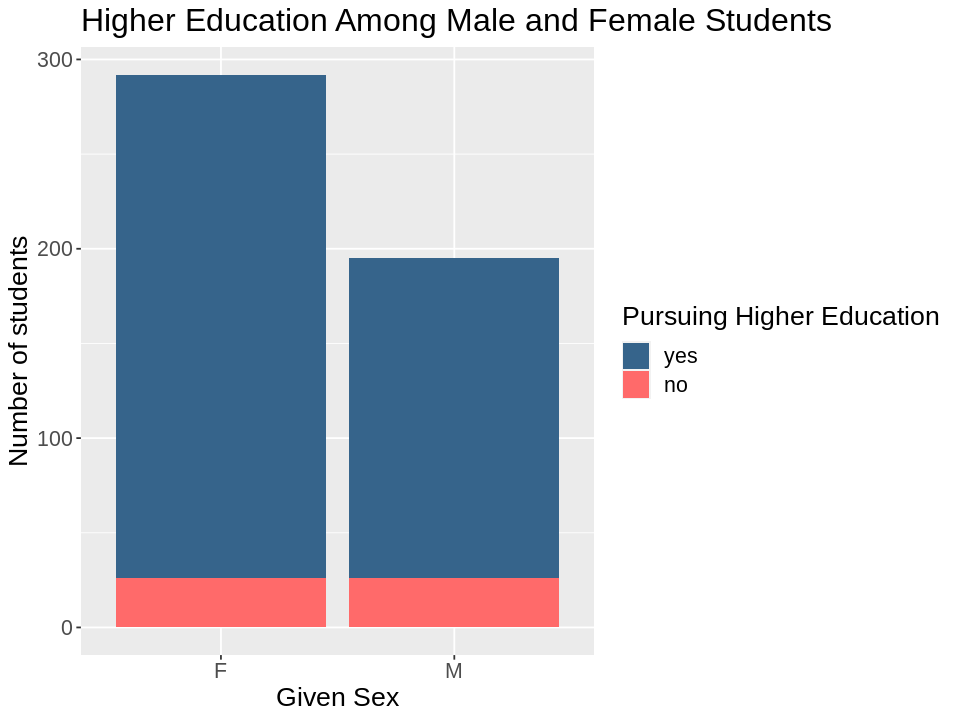

In [14]:
options(repr.plot.width=8, repr.plot.height=6)
# Distribution of student's choice by given sex
student_gender <- student_train %>%
                select(sex, higher) %>%
                ggplot(aes(x=sex, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Given Sex", y = "Number of students", fill = "Pursuing Higher Education", 
                     title = "Higher Education Among Male and Female Students")+
                theme(text = element_text(size=16))
student_gender

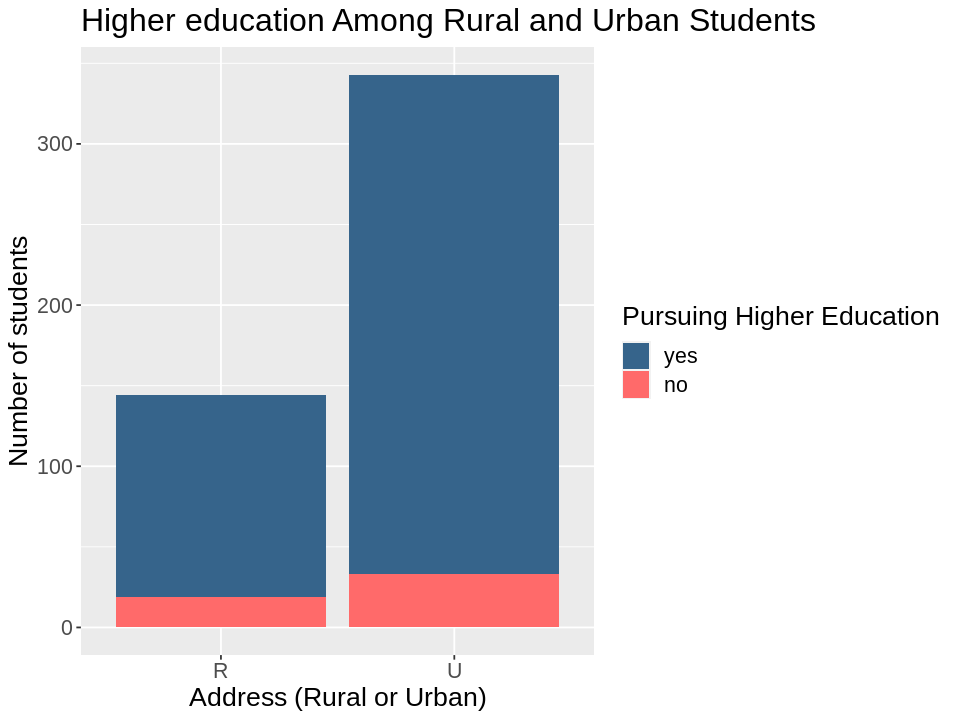

In [15]:
options(repr.plot.width=8, repr.plot.height=6)

# Distribution of student's choice by address (rural vs urban)
student_address <- student_train %>%
                select(address, higher) %>%
                ggplot(aes(x=address, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Address (Rural or Urban)", y = "Number of students", fill = "Pursuing Higher Education", 
                     title = "Higher education Among Rural and Urban Students")+
                theme(text = element_text(size=16))
student_address



`summarise()` regrouping output by 'address' (override with `.groups` argument)



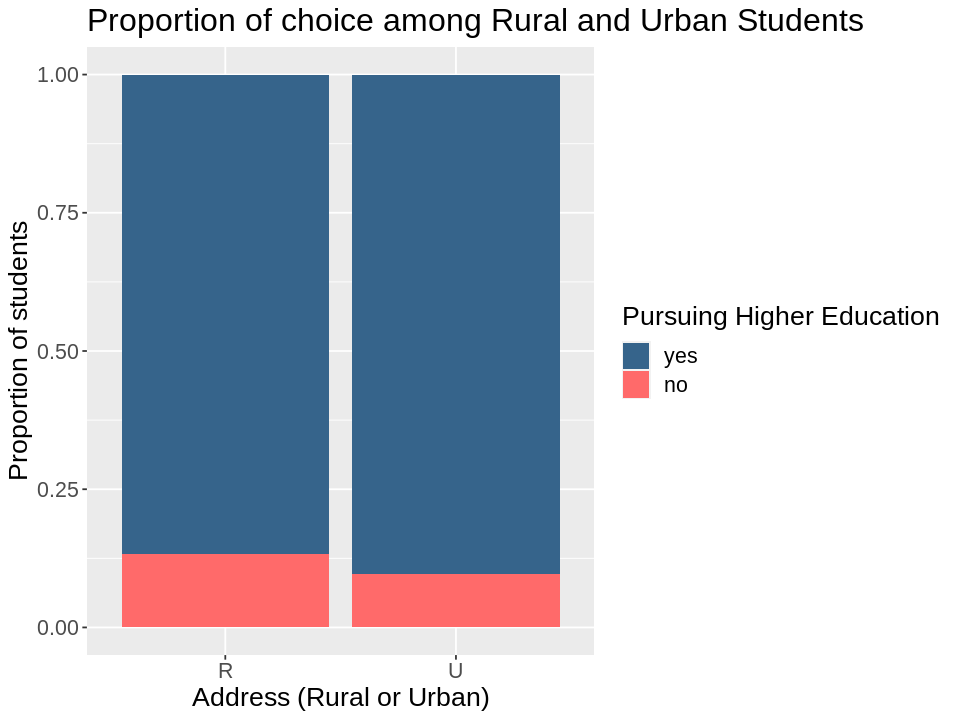

In [16]:
# Proportion of student's choice by address (rural vs urban)
address_n_higher <- student_train %>%
            select(address, higher)%>%
            group_by(address, higher)%>%
            summarize(n = n())
address_plot <- ggplot(address_n_higher, aes(x = address, y = n, fill = higher)) +
                    geom_bar(stat = "identity", position = "fill")+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Address (Rural or Urban)", y = "Proportion of students", fill = "Pursuing Higher Education",
                    title = "Proportion of choice among Rural and Urban Students")+
                theme(text = element_text(size=16))
address_plot

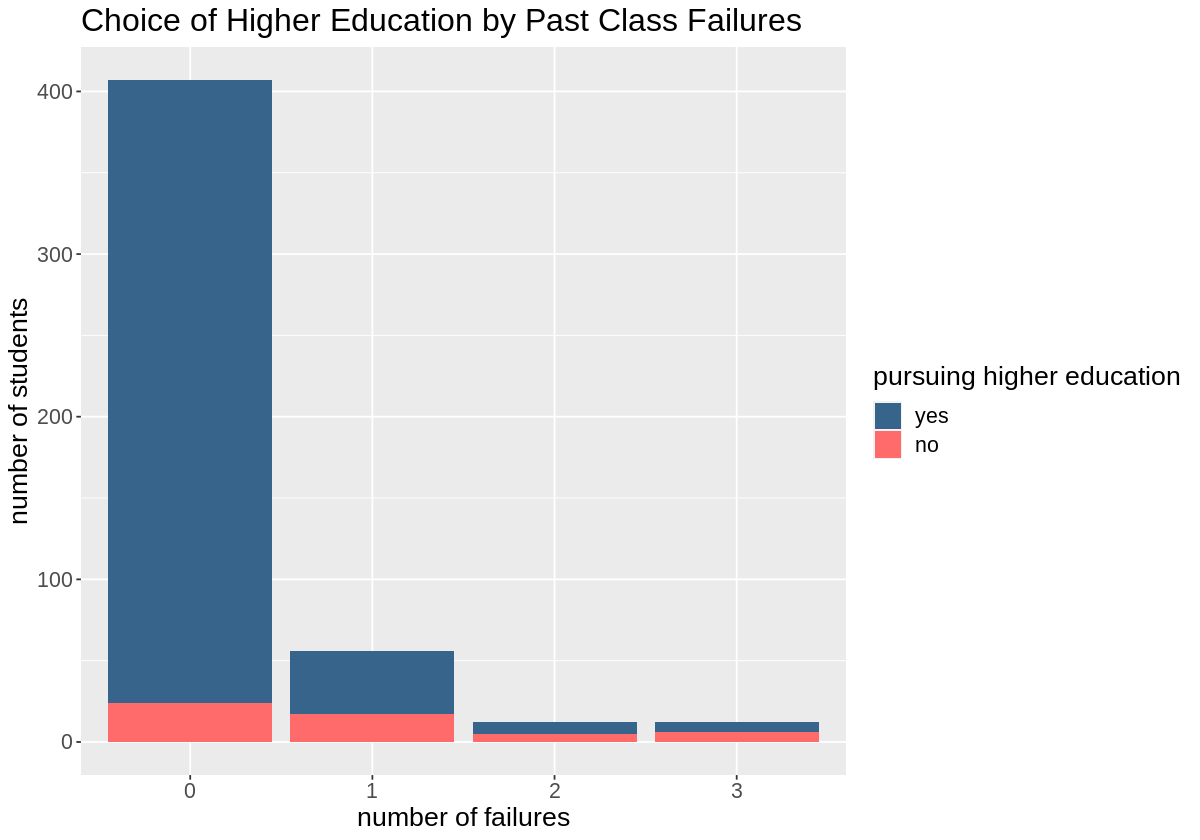

In [17]:
options(repr.plot.width=10, repr.plot.height=7)
# distribution of higher by number of previous class failures
student_failures <- student_train %>%
                select(failures, higher) %>%
                ggplot(aes(x=as.factor(failures), y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(y = "number of students", x = "number of failures", fill = "pursuing higher education",
                    title = "Choice of Higher Education by Past Class Failures")+
                theme(text = element_text(size=16))
student_failures

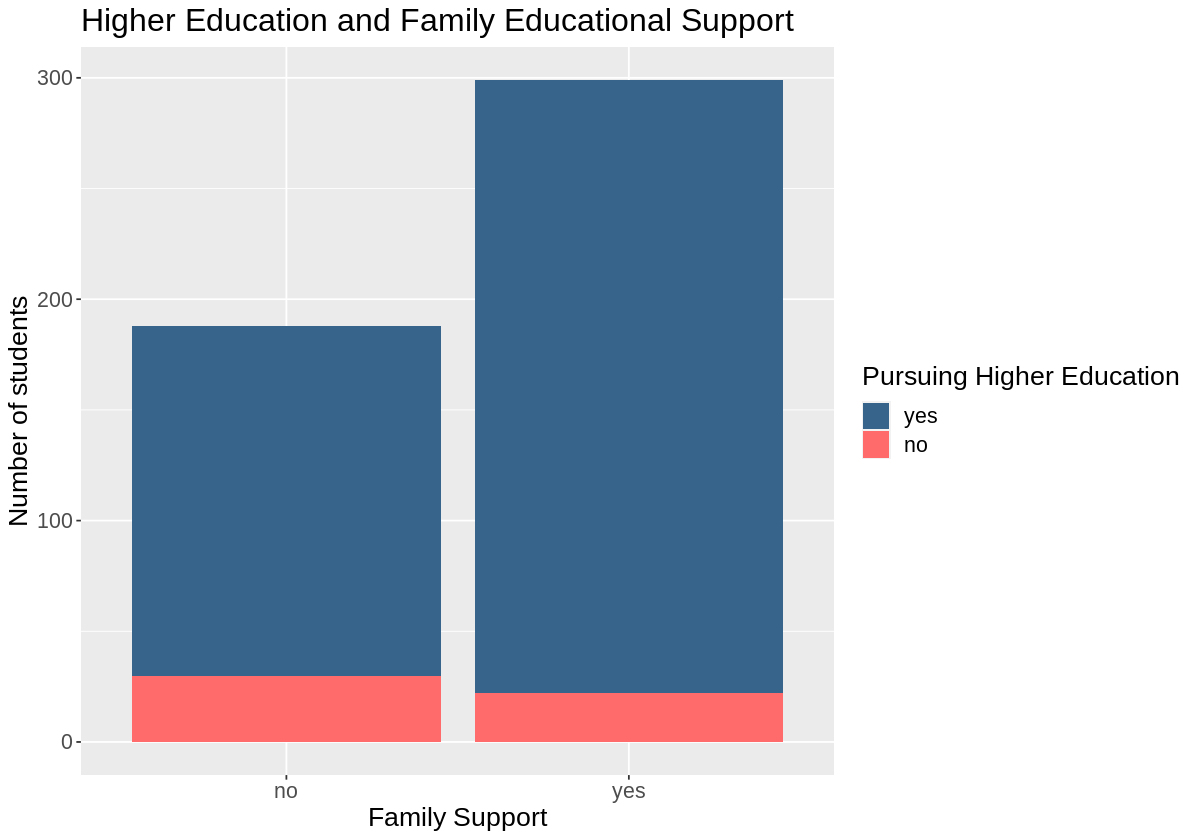

In [18]:
# Distribution of student's choice by family educational support
family_support <- student_train %>%
                select(famsup, higher) %>%
                ggplot(aes(x=famsup, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Family Support", y = "Number of students", fill = "Pursuing Higher Education",
                    title = "Higher Education and Family Educational Support")+
                theme(text = element_text(size=16))
family_support

## Methods

In order to create our prediction model, we will be looking at seven predictor variables: given sex, address (rural or urban), parents’ education, number of previous class failures, family educational support, and Portuguese course grades. 
 
We will use k-nearest neighbours to create and fit a model to our training data. We will split up the training set and use cross validation to tune the value of k. We will plot the estimated accuracy of each K value to determine the best k value. Once we have our predictions, we will evaluate our findings and display the result with a confusion matrix. 

To visualize the result, we will create graphs containing student’s Period 1 and Period 2 Portuguese grades vs. Final Portuguese grade, organizing the variable “higher”. This allows us to see the distribution of “higher” with respect to grades. We also want to visualize the distribution of our target variable (higher) with respect to the other categorical values. We will use bar graphs to show the number of students choosing yes or no depending on given categorical predictor variables.


## Expected outcomes and significance¶
We expect to see a relationship between the target variable, “higher education”, and the chosen predictor variables. We expect that we will be able to use these predictor variables to determine whether a student will choose to pursue higher education.

The impact of these findings could be very significant in that they can suggest reasons that would cause Portugese students to say no to higher education. Not only identifying the potential causes, these findings can help determine ways to support students and to encourage them to explore the idea of pursuing higher education. 

A few questions that our findings can lead to are:

* Why do certain aspects have such a sway on students opting for higher education?
* How can we reduce this gap?
* How can we provide resources to these students?

## Citation:
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. https://archive.ics.uci.edu/ml/datasets/Student+Performance#
